In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler,AutoencoderKL
import torch
from pytorch_lightning import seed_everything
from PIL import Image
from controlnet_aux import ZoeDetector


/workspace/SmartControl/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model_path = "SG161222/Realistic_Vision_V5.1_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
controlnet_path = "lllyasviel/control_v11f1p_sd15_depth"
depth_path = 'lllyasviel/Annotators'
smart_ckpt = "./depth.ckpt"
# negative_prompt_path = '/home/liuxiaoyu/compare/controlnet/realisticvision-negative-embedding'
device = "cuda"

load pretrain model

In [4]:
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)


vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet,vae=vae, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


extract depth

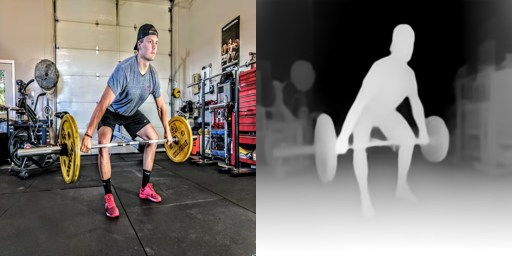

In [19]:

preprocessor = ZoeDetector.from_pretrained(depth_path)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


image = Image.open("assets/images/deadlift.jpg")
depth_map = preprocessor(image)
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

Forward

In [ ]:

prompt = 'a superman doing squat'

from smartcontrol import register_unet
pipe = register_unet(pipe,smart_ckpt)

seed_everything(42)
output = pipe(
    prompt=prompt,
    image=depth_map,
    # negative_prompt=negative_prompt_path,
    controlnet_conditioning_scale = 0.25

).images[0]

image_grid([ depth_map.resize((256, 256)),output.resize((256,256))], 1, 2)


Global seed set to 42
 68%|██████▊   | 34/50 [00:05<00:02,  6.60it/s]